<a href="https://colab.research.google.com/github/marianna718/Siamese_person_and_face_recognition/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [10]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


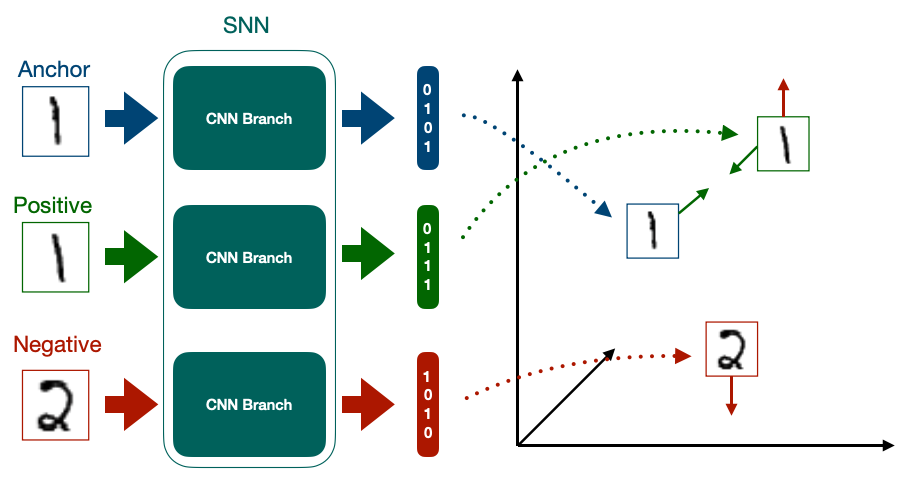

# Imports

In [11]:
# @title Default title text
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [15]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 20

DEVICE = 'cuda'

In [16]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [21]:
row = df.iloc[144]

A = io.imread(DATA_DIR + row.Anchor)
P = io.imread(DATA_DIR + row.Positive)
N = io.imread(DATA_DIR + row.Negative)

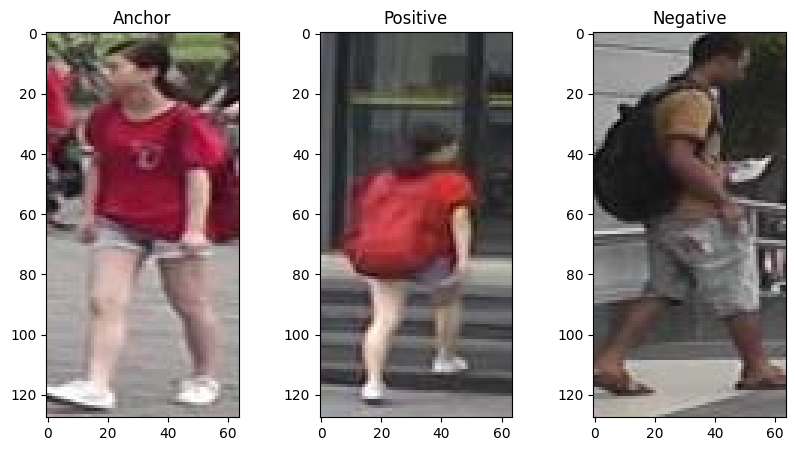

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A, cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P, cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N, cmap = 'gray')

In [23]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Create APN Dataset

In [36]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A = io.imread(DATA_DIR + row.Anchor)
    P = io.imread(DATA_DIR + row.Positive)
    N = io.imread(DATA_DIR + row.Negative)

    A = torch.from_numpy(A).permute(2,0,1) /255.0 #H,W,C -> C, H, W
    P = torch.from_numpy(P).permute(2,0,1) /255.0
    N = torch.from_numpy(N).permute(2,0,1) /255.0

    return A,P,N

In [37]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

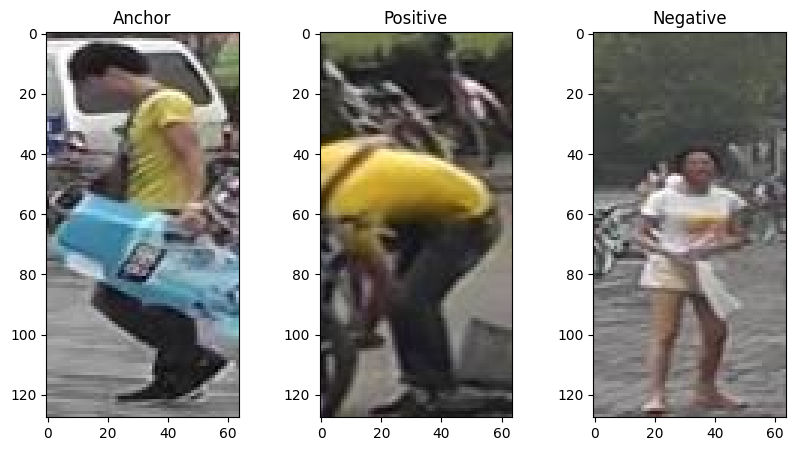

In [38]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [39]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [40]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [42]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [53]:
class APN_Model(nn.Module):
  def __init__(self,emb_size = 512 ):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=self.efficientnet.classifier.out_features)


  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings


In [54]:
model = APN_Model().to(DEVICE)

# Create Train and Eval function

In [55]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()  # Dropout ON
  total_loss = 0.0

  for A,P,N in tqdm(dataloader):
    A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A = model(A)
    P = model(P)
    N = model(N)

    loss = criterion(A, P, N)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [56]:
def eval_fn(model, dataloader, criterion):
  model.eval()  # Dropout OFF
  total_loss = 0.0

  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A = model(A)
      P = model(P)
      N = model(N)

      loss = criterion(A, P, N)

      total_loss += loss.item()

    return total_loss/len(dataloader)

In [57]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [58]:
best_valid_loss  = np.inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print ("Saved Weights Sucess")

  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss}")
  print(f"Valid Loss : {valid_loss}")



100%|██████████| 25/25 [00:03<00:00,  6.47it/s]


Saved Weights Sucess
Epoch : 1
Train Loss : 0.6914047005772591
Valid Loss : 0.5685894310474395


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Saved Weights Sucess
Epoch : 2
Train Loss : 0.34903237223625183
Valid Loss : 0.4237271547317505


100%|██████████| 25/25 [00:03<00:00,  7.64it/s]


Saved Weights Sucess
Epoch : 3
Train Loss : 0.21625395700335504
Valid Loss : 0.2557306373119354


100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


Epoch : 4
Train Loss : 0.13276817202568053
Valid Loss : 0.3316110169887543


100%|██████████| 25/25 [00:03<00:00,  8.04it/s]


Epoch : 5
Train Loss : 0.11684603914618492
Valid Loss : 0.34952765583992007


100%|██████████| 25/25 [00:03<00:00,  8.09it/s]


Saved Weights Sucess
Epoch : 6
Train Loss : 0.07593222722411155
Valid Loss : 0.18676778614521028


100%|██████████| 25/25 [00:03<00:00,  8.09it/s]


Epoch : 7
Train Loss : 0.057687545269727705
Valid Loss : 0.19132051944732667


100%|██████████| 25/25 [00:03<00:00,  7.95it/s]


Epoch : 8
Train Loss : 0.06243719056248665
Valid Loss : 0.2768947488069534


100%|██████████| 25/25 [00:03<00:00,  7.80it/s]


Epoch : 9
Train Loss : 0.04505746230483055
Valid Loss : 0.23597773611545564


100%|██████████| 25/25 [00:03<00:00,  8.07it/s]


Saved Weights Sucess
Epoch : 10
Train Loss : 0.034698420017957685
Valid Loss : 0.15251900672912597


100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


Saved Weights Sucess
Epoch : 11
Train Loss : 0.03828340247273445
Valid Loss : 0.14749081254005433


100%|██████████| 25/25 [00:03<00:00,  8.12it/s]


Epoch : 12
Train Loss : 0.027624232321977617
Valid Loss : 0.15980307281017303


100%|██████████| 25/25 [00:03<00:00,  8.05it/s]


Saved Weights Sucess
Epoch : 13
Train Loss : 0.018549871742725373
Valid Loss : 0.14713510274887084


100%|██████████| 25/25 [00:03<00:00,  7.90it/s]


Epoch : 14
Train Loss : 0.024501420259475708
Valid Loss : 0.24815110623836517


100%|██████████| 25/25 [00:03<00:00,  8.05it/s]


Epoch : 15
Train Loss : 0.07009611517190933
Valid Loss : 0.20351284682750703


100%|██████████| 25/25 [00:03<00:00,  7.81it/s]


Epoch : 16
Train Loss : 0.09063291378319263
Valid Loss : 0.1750340759754181


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Saved Weights Sucess
Epoch : 17
Train Loss : 0.038804282024502756
Valid Loss : 0.11436197996139526


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Epoch : 18
Train Loss : 0.010066628977656365
Valid Loss : 0.1293237489461899


100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Epoch : 19
Train Loss : 0.013912300765514373
Valid Loss : 0.12484197974205018


100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


Saved Weights Sucess
Epoch : 20
Train Loss : 0.01698129713535309
Valid Loss : 0.10834671586751937


# Get Anchor Embeddings

In [60]:
def  get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) #C, H, W -> BS, C, H, W  and the BS = 1
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [61]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [01:02<00:00, 64.47it/s]


In [62]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,1420_c5s3_052165_01.jpg,0.625349,-0.531579,-0.708216,1.016747,-0.507961,0.283103,-0.130735,0.426218,0.116767,...,-0.829530,0.024702,-0.151166,0.409398,0.279346,-0.385258,0.543556,-0.142967,-0.231409,-0.259298
1,1420_c3s3_061978_03.jpg,0.479788,-0.485219,-0.635575,0.643353,-0.803263,0.107714,-0.117183,0.311639,0.058880,...,-0.499007,-0.007771,-0.242130,0.408514,0.176113,-0.205771,0.415702,0.101601,0.077644,-0.163455
2,1420_c5s3_062565_05.jpg,0.489440,-0.489577,-0.439594,0.788497,-0.798094,0.276140,-0.312942,0.367555,0.111857,...,-0.739564,-0.138474,-0.132272,0.528306,0.240589,-0.317842,0.445577,0.039978,-0.172124,-0.275966
3,1420_c6s3_085592_04.jpg,0.644506,-0.497484,-0.738281,0.720598,-0.848933,0.463556,0.007176,0.330389,-0.136577,...,-0.672560,0.099211,-0.256691,0.318020,0.151320,-0.438576,0.364521,0.232632,-0.463566,-0.370652
4,0663_c5s3_085987_03.jpg,0.665515,-0.188138,-0.023575,0.251227,-0.166860,0.423235,1.078459,-0.154654,-0.654452,...,0.008048,0.705648,0.162055,-0.159849,-0.053749,-0.300968,-0.236653,0.941394,-1.124768,-0.304668


# Inference

In [63]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc-anc_enc_arr.T)))
  return dist

In [64]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR+img_name
img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [65]:
distance = []
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
  distance = np.append(distance, dist)


<ipython-input-63-d4a45eee35c8>:2: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc-anc_enc_arr.T)))


In [66]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/layout.py:728: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


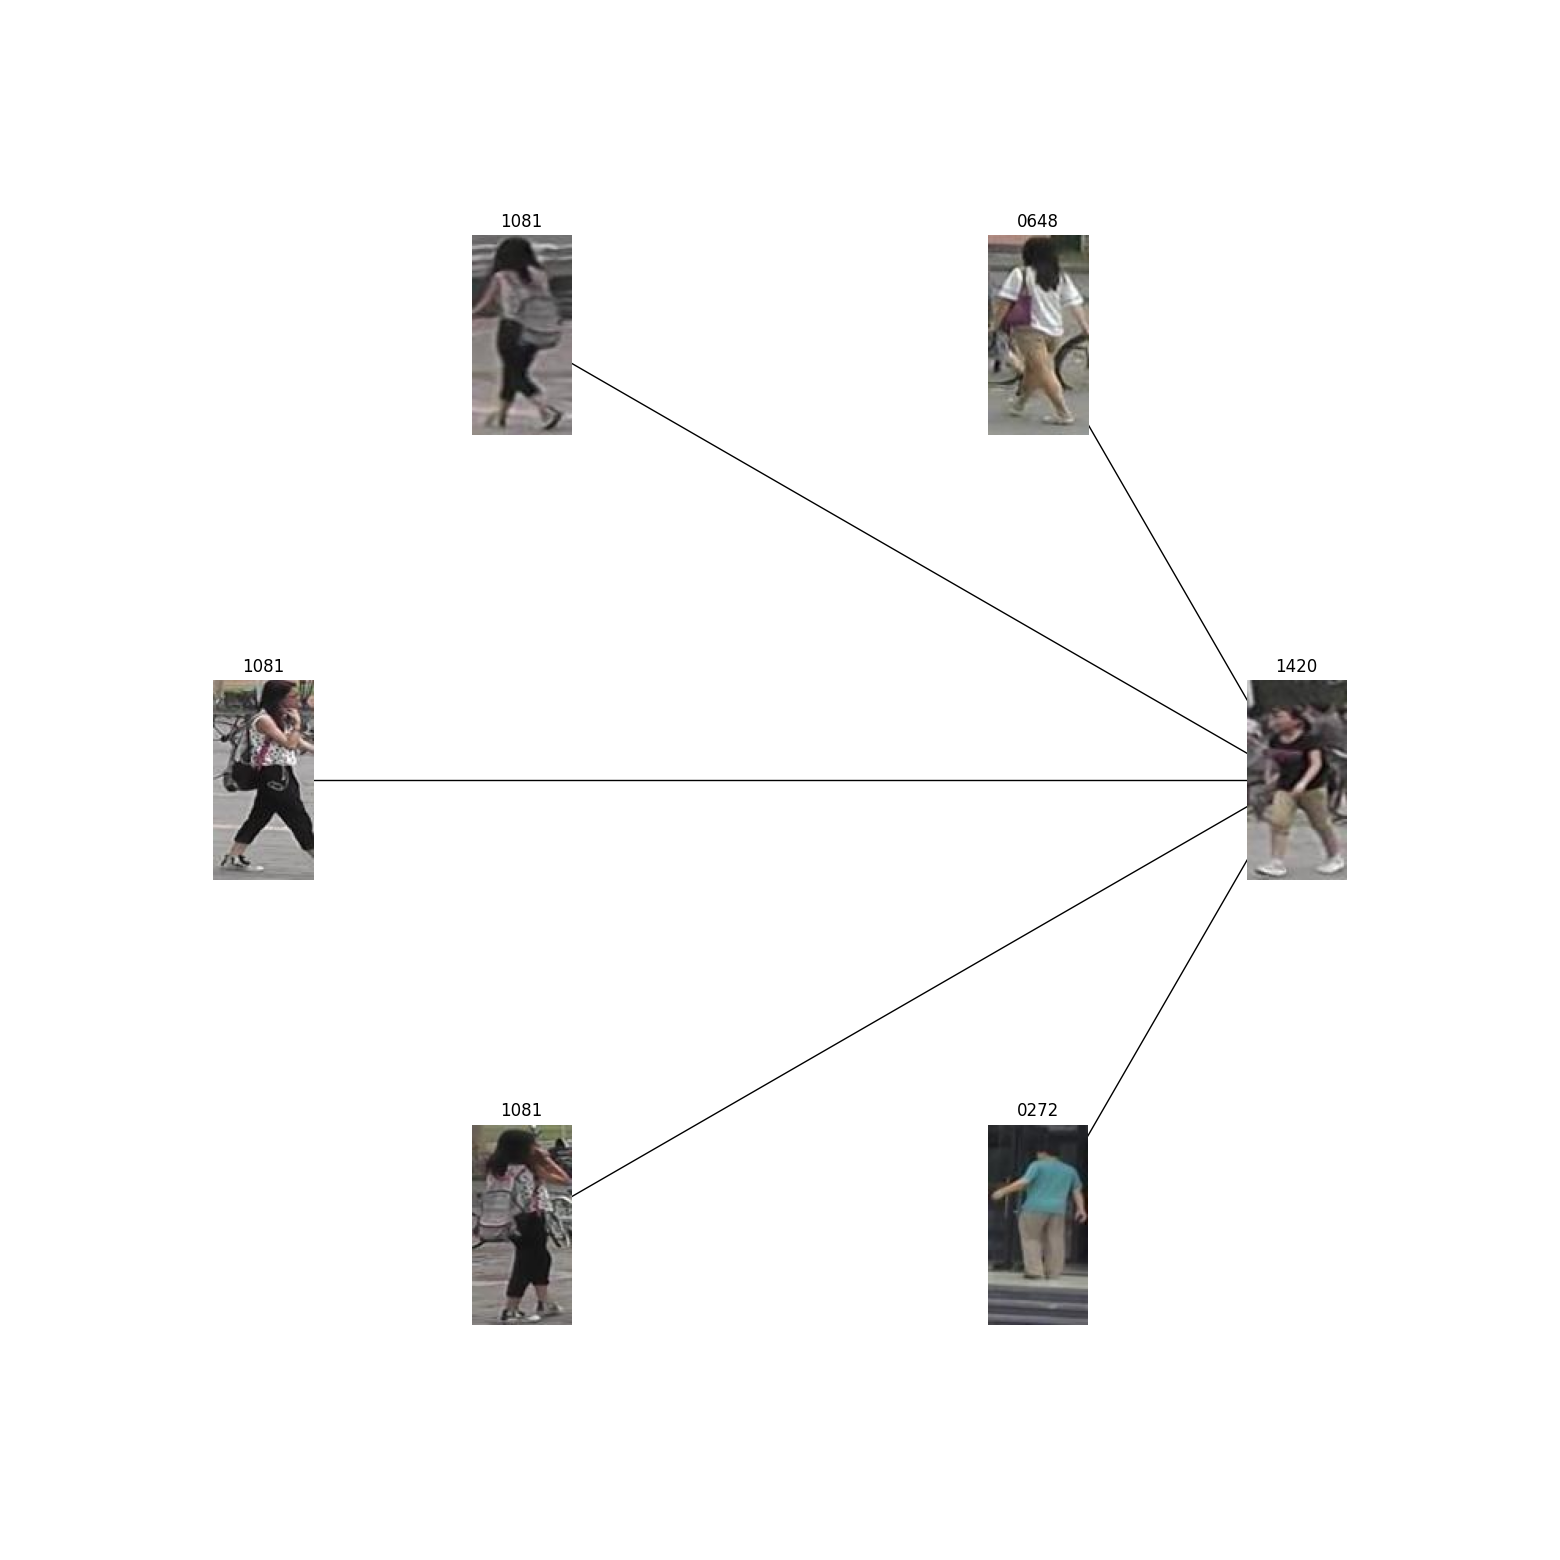

In [67]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);